# Part 1- Sentiment analysis of stock news

## Import the libraries

In [112]:
import os
import numpy as np
import pandas as pd
import yfinance as yf
%matplotlib inline
from newsapi import NewsApiClient
from datetime import datetime, timedelta
from dotenv import load_dotenv
load_dotenv()

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Fetch the stock OHLC

In [2]:
# Yahoo finance is used
stock_data= yf.download(tickers= 'MSFT', period= '5y')
stock_data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-05,217.259995,218.520004,215.699997,217.899994,217.899994,23823000
2021-01-06,212.169998,216.490005,211.940002,212.250000,212.250000,35930700
2021-01-07,214.039993,219.339996,213.710007,218.289993,218.289993,27694500
2021-01-08,218.679993,220.580002,217.029999,219.619995,219.619995,22956200
2021-01-11,218.470001,218.910004,216.729996,217.490005,217.490005,23031300


In [3]:
# Get only the closing price and round to 2 decimals
stock_close= round (stock_data['Close'], 2)
stock_close.tail()

Date
2021-01-05    217.90
2021-01-06    212.25
2021-01-07    218.29
2021-01-08    219.62
2021-01-11    217.49
Name: Close, dtype: float64

In [4]:
# Calculate the daily returns
returns= stock_close.pct_change()*100
returns.tail()

Date
2021-01-05    0.096467
2021-01-06   -2.592933
2021-01-07    2.845701
2021-01-08    0.609281
2021-01-11   -0.969857
Name: Close, dtype: float64

In [5]:
# Convert to a dataframe and sort by descending date
returns_df= pd.DataFrame(returns)
returns_df.sort_index(ascending= False, inplace= True)

returns_df.rename(columns= {'Close':'pct_change'}, inplace= True)
returns_df.head()

,pct_change
Date,
2021-01-11,-0.969857
2021-01-08,0.609281
2021-01-07,2.845701
2021-01-06,-2.592933
2021-01-05,0.096467


### Download the VADER Lexicon

In [6]:
nltk.download('vader_lexicon')

# Initialize the sentiment analyzer
analyzer= SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\sathe\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


### Fetch the news

In [7]:
# Import the libraries
import requests
import json

In [8]:
# Check for the STOCK_NEWS_API key
stock_news_api= os.getenv("STOCK_NEWS_API")
type (stock_news_api)

str

In [9]:
# Define the base request URL
request_url = "https://stocknewsapi.com/api/v1?tickers=MSFT&items=50&token="

# Concatenate request_url and api_key. Store as new variable
request_url= request_url+ stock_news_api

In [10]:
# Execute get request
response_data= requests.get(request_url).json()

In [11]:
# Print the response data
print (json.dumps (response_data, indent= 4))

{
    "data": [
        {
            "news_url": "https://seekingalpha.com/article/4398433-dogs-of-dow-plan-to-improve-on-market-beating-strategy",
            "image_url": "https://cdn.snapi.dev/images/v1/u/q/stocks-this-week-sell-short-amgen-and-kraft-heinz.jpg",
            "title": "The Dogs Of The Dow: My Plan To Improve On The Market Beating Strategy",
            "text": "Data indicates The Dogs of the Dow outperform over long time frames. I contend the Dogs provide a good risk/reward profile for Dividend Growth investors.",
            "source_name": "Seeking Alpha",
            "date": "Mon, 11 Jan 2021 23:39:07 -0500",
            "topics": [
                "paylimitwall"
            ],
            "sentiment": "Neutral",
            "type": "Article",
            "tickers": [
                "AMGN",
                "CSCO",
                "CVX",
                "DOW",
                "IBM",
                "KO",
                "MMM",
                "MSFT",
              

## Get the news text, date and the sentiment from response data

In [52]:
def combined_df(text):
    all_dates= []
    all_articles= []
    all_sentiments= []
    
    for article in text['data']:
        date= all_dates.append(article['date'])
        articles= all_articles.append(article['text'])
        sentiments= all_sentiments.append(article['sentiment'])
        text_sentiments= pd.DataFrame ({
            'date': date,
            'articles':articles,
            'sentiments':sentiments,
        }
        )
    return text_sentiments

In [55]:
# for article in response_data['data']:
#     print (article['sentiment'])

In [56]:
# text_sentiment_df= combined_df(response_data )
# text_sentiment_df.head()

In [57]:
all_articles= []
all_sentiments= []
all_dates= []
for article in response_data['data']:
    all_articles.append(article['text'])
    all_sentiments.append(article['sentiment'])
    all_dates.append(article['date'])

In [58]:
all_articles_df= pd.DataFrame(all_articles, columns= ['text'])
all_sentiments_df= pd.DataFrame(all_sentiments, columns= ['sentiment'])

all_dates_df= pd.DataFrame(all_dates, columns= ['date'])
all_dates_df['date']= pd.to_datetime(all_dates_df['date']).dt.date


text_sentiment= pd.concat([all_dates_df, all_articles_df, all_sentiments_df], axis= 1)
text_sentiment.head()

,date,text,sentiment
0,2021-01-11,Data indicates The Dogs of the Dow outperform ...,Neutral
1,2021-01-11,Microsoft (MSFT) closed the most recent tradin...,Negative
2,2021-01-11,We have a very interesting week ahead full of ...,Positive
3,2021-01-11,Microsoft employees didn't agree with some rec...,Neutral
4,2021-01-11,President Trump expected to take a final stand...,Negative


In [59]:
# Set the date as index
text_sentiment.set_index('date', inplace= True)
text_sentiment.head()

,text,sentiment
date,,
2021-01-11,Data indicates The Dogs of the Dow outperform ...,Neutral
2021-01-11,Microsoft (MSFT) closed the most recent tradin...,Negative
2021-01-11,We have a very interesting week ahead full of ...,Positive
2021-01-11,Microsoft employees didn't agree with some rec...,Neutral
2021-01-11,President Trump expected to take a final stand...,Negative


In [60]:
# Merge the pct change with the above df
text_sentiment_returns= pd.merge(text_sentiment, returns_df, left_index= True, right_index= True)
text_sentiment_returns.sort_index(ascending= False, inplace= True)
text_sentiment_returns.head()

,text,sentiment,pct_change
2021-01-11,We are often asked what stocks we are buying a...,Negative,-0.969857
2021-01-11,These best tech stocks to buy are all coming o...,Positive,-0.969857
2021-01-11,Data indicates The Dogs of the Dow outperform ...,Neutral,-0.969857
2021-01-11,We have a very interesting week ahead full of ...,Positive,-0.969857
2021-01-11,Microsoft employees didn't agree with some rec...,Neutral,-0.969857


In [61]:
text_sentiment_returns.reset_index(inplace= True)
text_sentiment_returns.head()

,index,text,sentiment,pct_change
0,2021-01-11,We are often asked what stocks we are buying a...,Negative,-0.969857
1,2021-01-11,These best tech stocks to buy are all coming o...,Positive,-0.969857
2,2021-01-11,Data indicates The Dogs of the Dow outperform ...,Neutral,-0.969857
3,2021-01-11,We have a very interesting week ahead full of ...,Positive,-0.969857
4,2021-01-11,Microsoft employees didn't agree with some rec...,Neutral,-0.969857


### Create the sentiment scores DF

In [62]:
polarity= []

for content in text_sentiment_returns['text']:
    try:
        # Calculate the polarity score
        sentiment= analyzer.polarity_scores(content)
        compound= sentiment['compound']
#         positive= sentiment['pos']
#         negative= sentiment['neg']
#         neutral= sentiment['neu']
        
        polarity.append({
            "compound": compound,
#             "positive": positive,
#             "negative": negative,
#             "neutral": neutral
        })
        
    except AttributeError:
        pass
    
# Create dataframe
polarity_df= pd.DataFrame(polarity)
polarity_df.head()

,compound
0,0.1989
1,0.8957
2,0.6908
3,0.4576
4,-0.2755


In [80]:
text_sentiment_returns_polarity= pd.concat([text_sentiment_returns, polarity_df], axis= 1)
text_sentiment_returns_polarity.set_index('index', inplace= True)
text_sentiment_returns_polarity.head()

,text,sentiment,pct_change,compound
index,,,,
2021-01-11,We are often asked what stocks we are buying a...,Negative,-0.969857,0.1989
2021-01-11,These best tech stocks to buy are all coming o...,Positive,-0.969857,0.8957
2021-01-11,Data indicates The Dogs of the Dow outperform ...,Neutral,-0.969857,0.6908
2021-01-11,We have a very interesting week ahead full of ...,Positive,-0.969857,0.4576
2021-01-11,Microsoft employees didn't agree with some rec...,Neutral,-0.969857,-0.2755


## Tokenization, Lemmatization

In [81]:
# Importing the Libraries and Functions
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
import re

In [82]:
# Instantiate the lemmatizer
lemmatizer= WordNetLemmatizer()

In [83]:
def tokenizer(text):
    """Tokenizes text."""
    
    # Remove the stop words
    stop_words= set (stopwords.words('english'))
   
    # Remove the punctuation and substitute
    non_alpha= re.compile('[^a-zA-Z ]')
    re_clean= non_alpha.sub('', str (text))
    
    # Tokenize the words
    words= word_tokenize(re_clean)
    
    # Lemmatize Article words into root words
    root_words= []
    for values in words:
        root_words.append(lemmatizer.lemmatize(values))
        
    # Remove stop words and Convert the words to lowercase
    tokens= []
    for all_words in root_words:
        if all_words.lower() not in stop_words:
            tokens.append(all_words.lower())
    
    return tokens

In [84]:
# Apply the tokenizer function to the news text column
text_sentiment_returns_polarity['tokenized']= text_sentiment_returns_polarity['text'].apply(tokenizer)
text_sentiment_returns_polarity.head()

,text,sentiment,pct_change,compound,tokenized
index,,,,,
2021-01-11,We are often asked what stocks we are buying a...,Negative,-0.969857,0.1989,"[often, asked, stock, buying, understanding, w..."
2021-01-11,These best tech stocks to buy are all coming o...,Positive,-0.969857,0.8957,"[best, tech, stock, buy, coming, solid, perfor..."
2021-01-11,Data indicates The Dogs of the Dow outperform ...,Neutral,-0.969857,0.6908,"[data, indicates, dogs, dow, outperform, long,..."
2021-01-11,We have a very interesting week ahead full of ...,Positive,-0.969857,0.4576,"[interesting, week, ahead, full, earnings, rep..."
2021-01-11,Microsoft employees didn't agree with some rec...,Neutral,-0.969857,-0.2755,"[microsoft, employee, didnt, agree, recent, po..."


## N-grams, WordCloud

In [85]:
# Import the libraries and functions
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [15.0, 15.0]

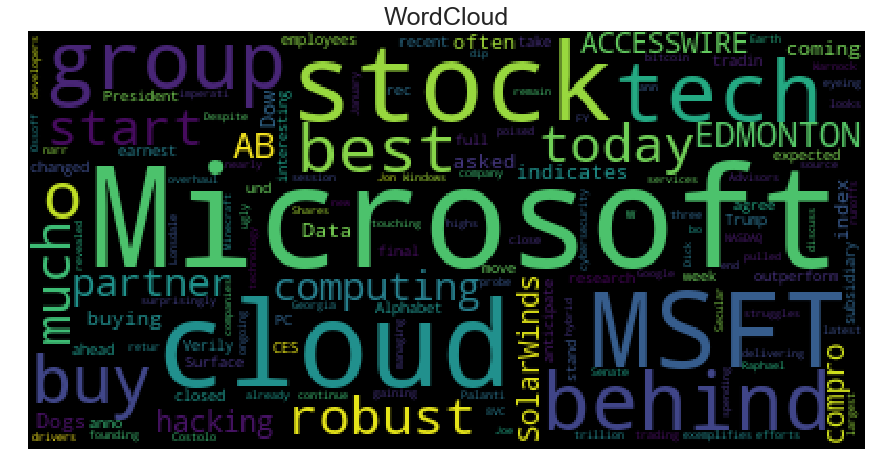

In [86]:
# Generate the word cloud
returns_big_text= ''.join (str (text_sentiment_returns_polarity["text"]))

returns_wc= WordCloud().generate(returns_big_text)

plt.imshow(returns_wc)
plt.axis("off")
plt.title('WordCloud', fontsize= 25)
plt.show()

## Regression and Deep Learning prediction of returns

In [97]:
# Create a train/test split for the data
train= text_sentiment_returns_polarity['2020-12']
test= text_sentiment_returns_polarity['2021-01']

In [106]:
# Create X_train, X_test, y_train, y_test
X_train= train['compound'].to_frame()
y_train= train['pct_change']

X_test= test['compound'].to_frame()
y_test= test['pct_change']

In [107]:
# Create a linear regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

lr_model= LinearRegression()
lr_model.fit (X_train, y_train)

LinearRegression()

## Make predictions using the test data

In [109]:
# Make a prediction of "y" values using just the test dataset
lr_predictions= lr_model.predict(X_test)

In [117]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a DataFrame:
results= y_test.to_frame()
results['predicted return']= lr_predictions
results.head()

,pct_change,predicted return
index,,
2021-01-11,-0.969857,0.089926
2021-01-11,-0.969857,-0.741500
2021-01-11,-0.969857,-0.497012
2021-01-11,-0.969857,-0.218757
2021-01-11,-0.969857,0.655983


array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000026C2D7E3CC8>,
      dtype=object)

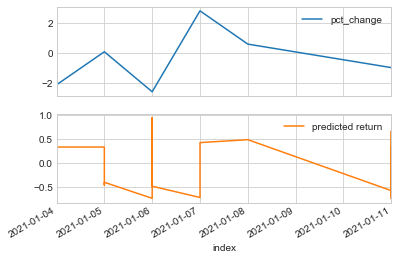

In [113]:
results.plot(subplots= True)

# Part 2- Stock technical analysis

In [ ]:
# Import the libraries
from ta import add_all_ta_features
from ta.utils import dropna

In [ ]:
# The stock data for the last 5 years has been downloaded in the beginning
# Get the technical indicators
tech_indicators= add_all_ta_features(stock_data, open="Open", high="High", low="Low", close="Close", volume="Volume")
tech_indicators.head()

In [ ]:
tech_indicators.tail()

In [ ]:
tech_indicators.columns

### Data preparation

In [ ]:
# Count the null values
tech_indicators.isnull().sum()

In [ ]:
# Fill the null values with 0.
tech_indicators.fillna(0, inplace= True)

In [ ]:
tech_indicators.isnull().sum().sum()

In [ ]:
# Sort the index by descending date
tech_indicators.sort_index(ascending= False, inplace= True)
tech_indicators.tail()

In [ ]:
# # Create the feature and target data
# X= tech_indicators.drop(columns= ['Close'])

# y= tech_indicators['Close']

In [ ]:
tech_indicators.describe()

## Linear Regression with Train/Test split

In [ ]:
# Create a train-test split
train= tech_indicators['2019':'2016']
test= tech_indicators['2021':'2020']

In [ ]:
# Assign X_train, X_test, y_train, y_test
X_train= train.drop(columns= ['Close'])
y_train= train['Close']

X_test= test.drop(columns= ['Close'])
y_test= test['Close']

In [ ]:
# Create a linear regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a sklearn linear regression using just the training set
lr_model= LinearRegression()
lr_model.fit(X_train, y_train)

## Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [ ]:
# Make a prediction of y values using the test dataset
lr_predictions= lr_model.predict(X_test)

In [ ]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
results= y_test.to_frame()
results['Predicted Returns']= lr_predictions
results.head()

In [ ]:
results.plot(subplots= True)

## Out-of-Sample Performance

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
mse= mean_squared_error (results['Close'],
                        results['Predicted Returns'])

# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
out_of_sample_rmse = np.sqrt(mse)
print(f"Out-of-Sample Root Mean Squared Error (RMSE): {out_of_sample_rmse}")